In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

### Loading and understanding the data

In [2]:
data=pd.read_json('./data/train_reviews.json')

In [3]:
# concise summary and characterstics
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2021 entries, 0 to 2020
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   date    2021 non-null   datetime64[ns, UTC]
 1   title   2021 non-null   object             
 2   text    2021 non-null   object             
 3   url     2021 non-null   object             
 4   stars   2021 non-null   object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 79.1+ KB


We can see that there are five attribute columns with no missing values. Moreover, one of the attributes is a potential time stamp and rest of them are textual features.

In [4]:
# Let's see how the data looks like with values. A glance over the dataset
data.head(3)

,date,title,text,url,stars
0,2015-10-10 14:32:51+00:00,Bad customer service. Staff are very impolite ...,Used national rail twice and on both occasions...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
1,2015-09-22 17:04:56+00:00,Pretty awful service,I phoned National rail to find out why several...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium
2,2015-03-13 23:37:05+00:00,Awful staff,I travel from Brokenhast to southampton centra...,https://uk.trustpilot.com/review/www.nationalr...,star-rating star-rating-1 star-rating--medium


We cannot use the data as it is. We need to process some of the features to extract relevant informations i.e. rating star as a numeric value from the 'stars' columns.

### Preprocessing

First look at the different attribute columns and extract usefull information

In 'stars' column two values can be important: 1) rating star as 1,2,3,4,5. and 2) level as 'medium'. 
Looking at the dataset it seems like level ('medium') is constant. If this is the case then we would be 
only interested in rating star's numceric values. First, we have to make sure if our assumption is true or not.


In [5]:
data.stars.str.split(' ').str[-1].unique()

array(['star-rating--medium'], dtype=object)

So our assumpotion is true that 'star-rating-medium' is constant across all the values in 'stars'. So we would be only interested in numeric value i.e. rating star. Let's extract rating stars numeric values from 'stars' and keep that as a new feature 'star_rating'.

In [6]:
data['star_rating']=data['stars'].str.findall(r'\d+').str[-1]

In [7]:
data['star_rating'].head()

0    1
1    1
2    1
3    4
4    4
Name: star_rating, dtype: object

Next comes 'url' attribute. Let's see if it is useful or not and what sort of information we can collect from this.

In [8]:
data['url'].head(10)

0    https://uk.trustpilot.com/review/www.nationalr...
1    https://uk.trustpilot.com/review/www.nationalr...
2    https://uk.trustpilot.com/review/www.nationalr...
3    https://uk.trustpilot.com/review/www.nationalr...
4    https://uk.trustpilot.com/review/www.nationalr...
5    https://uk.trustpilot.com/review/www.nationalr...
6    https://uk.trustpilot.com/review/www.nationalr...
7    https://uk.trustpilot.com/review/www.nationalr...
8    https://uk.trustpilot.com/review/www.nationalr...
9    https://uk.trustpilot.com/review/www.nationalr...
Name: url, dtype: object

By looking at the 'url' we can see that it can provide information regarding the train type. So we should be interested to clean it and extract only the train names from each url. We extract the train types and store them in new attribute 'train_type'.

In [9]:
data['train_type']=data['url'].str.split('/').str[-1]

In [10]:
data['train_type']=data['train_type'].str.replace('www.','').str.replace('buytickets.','').str.split('.').str[0]

In [11]:
data['train_type'].unique()

array(['nationalrail', 'sleeper', 'eastmidlandstrains', 'virgintrains',
       'virgintrainseastcoast', 'eurostar', 'arrivatrainswales',
       'crosscountrytrains', 'chilternrailways', 'southernrailway', 'gwr',
       'grandcentralrail', 'tpexpress', 'hulltrains',
       'southwesternrailway', 'londonnorthwesternrailway',
       'southeasternrailway'], dtype=object)

So now we know that this data is all about 17 different train lines.

after cleaning the rating stars and trains data 

In [12]:
data.drop(['stars','url'], inplace=True, axis=1)

### Text Processing and Cleaning

As we know that text and title fields in the data contain especial characters as well as numeric character. These may not be helpful for topic modeling or further text processing. Let's clean the text by removing all the especial and numeric characters. 

In [13]:
data['title']=data['title'].str.replace(r'[-()£\"#/@*;:<>{}=~|.?,]','').str.replace(r'\d+|\w*\d+\w*\s','')
data['text']=data['text'].str.replace(r'[-()£\"#/@*;:<>{}=~|.?,]','').str.replace(r'\d+|\w*\d+\w*\s','')

After cleaning there may be few fields that remain empty. It may be because there were only numeric or special characters there. So replace that empty field with nan. 

In [14]:
sum(data['title'].str.len()==0)

1

We can see that there is a field which is empty or of length 0. So replace all such sort of fields of 'title' or 'text' with nan and then drop those nan rows.

In [15]:
data['title']=data['title'].replace(r'^\s*$', np.nan, regex=True).str.lower()
data['text']=data['text'].replace(r'^\s*$', np.nan, regex=True).str.lower()
data.dropna(inplace=True)
data=data.reset_index(drop=True)

We are almost done with the text cleaning now lets look at the length of the texts

669 1 60.85742574257426


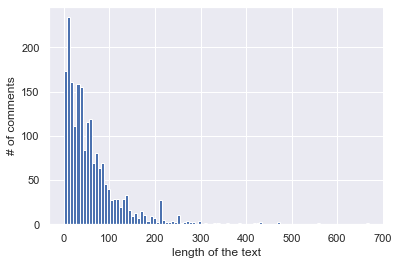

In [16]:
text_length=data['text'].str.split(' ').str.len()
print(max(text_length),min(text_length),np.mean(text_length))
text_length.hist(bins=100)
plt.xlabel('length of the text')
plt.ylabel('# of comments')
plt.show()

By looking at the lengths of all the texts in 'text' we can see that data is quite sparse in term of length. There are some outliers with super lengthy texts. However, Let's see the texts with length 1.

In [17]:
d=data['text'].str.split(' ').str.len()==1
outliers=[i for i, x in enumerate(d) if x]
print(outliers)
data.iloc[outliers,:]

[608, 703, 781, 974, 1133, 1334, 1374, 1641]


,date,title,text,star_rating,train_type
608,2017-10-04 13:23:04+00:00,wifi mostly didn’t work for hour journey exce...,cons,2,virgintrains
703,2017-07-28 10:17:44+00:00,dreadful avoid where possible,dreadful,1,virgintrains
781,2017-06-07 17:40:31+00:00,hello,hello,1,virgintrains
974,2016-05-09 22:33:27+00:00,mess up with their central computer system cos...,updated,4,virgintrains
1133,2018-04-13 15:10:49+00:00,they still haven't learned what good service is,hello,1,eurostar
1334,2016-12-02 10:23:33+00:00,terrible customer service and signage at gare ...,eurostar,1,eurostar
1374,2017-08-02 08:49:43+00:00,traumatised,traumatised,1,eurostar
1641,2016-07-01 19:39:49+00:00,just simply rubbish,incompetent,1,southernrailway


It seems all the fields with single word may be interesting to consider. But more importantly it would be worthful to consider title+text togther.

In [18]:
data['comments']=data['title']+' '+data['text']

Further clean the 'comments': remove stop words and apply lemmatization to make data more consistent.

In [19]:
import en_core_web_sm
nlp = en_core_web_sm.load()

import spacy

#nlp = spacy.load('en_core_web_sm')
stopwords = spacy.lang.en.stop_words.STOP_WORDS

def text_process(text):
    
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stopwords]
    
    return ' '.join(a_lemmas)

data['comments']=data['comments'].apply(text_process)

data['comments']

0       bad customer service staff impolite rude natio...
1       pretty awful service phone national rail find ...
2       awful staff travel brokenhast southampton cent...
3       good save single trip use nationalrail pick sp...
4       check use national rail enquiry site plan rail...
                              ...                        
2015    late late cancel signal failure rain sunnythes...
2016    sure timetable train constantly delay cancel s...
2017    helpful guard yearly basis group preschool chi...
2018    late clean decent travel day like newish train...
2019    train service improve customer service dreadfu...
Name: comments, Length: 2020, dtype: object

### Exploratory Data Analysis

Lets look at the distribution of the stars. 

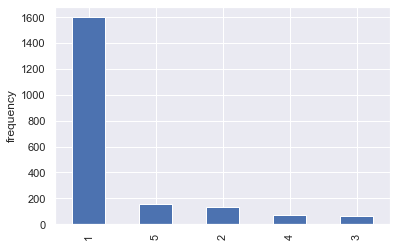

In [20]:
data['star_rating'].value_counts().plot.bar()
plt.ylabel('frequency')
plt.show()

The majority of comments are potentially negative so mostly passengers are not satisfied with the services.

The distribution of the number of comments with respect to each train line.

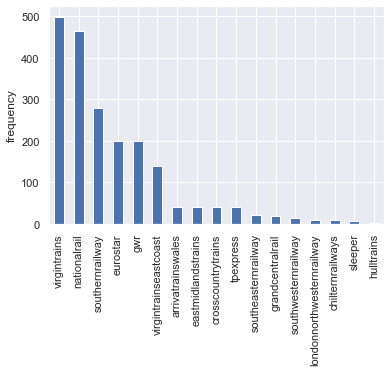

In [21]:
data['train_type'].value_counts().plot.bar()
plt.ylabel('frequency')
plt.show()

Here, we see that majority of the comments (>100) are related to the six train lines.

Now lets see what is the average star rating per train line.

In [22]:
data['star_rating']=data['star_rating'].astype('int')
rail_star_stats=data[['train_type','star_rating']].groupby(['train_type'])['star_rating'].agg(['count','mean','std']).round(1)
rail_star_stats

,count,mean,std
train_type,,,
arrivatrainswales,40,1.7,1.4
chilternrailways,8,2.1,1.6
crosscountrytrains,40,1.0,0.0
eastmidlandstrains,40,1.4,1.1
eurostar,200,1.4,1.0
grandcentralrail,19,1.8,1.3
gwr,200,1.3,0.9
hulltrains,2,4.5,0.7
londonnorthwesternrailway,8,1.1,0.4


Most of the averages ratings are less then 2.0.

Lets see how to star distribution for each train lines.

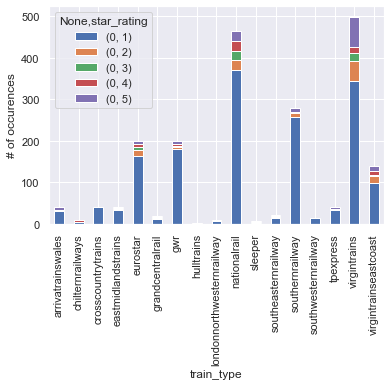

In [23]:
data[['train_type','star_rating']].groupby(['train_type','star_rating']).size().sort_values().to_frame().unstack().plot(kind = "bar",stacked=True,legend=True)
plt.ylabel('# of occurences')
plt.show()

We can see more than 70% percent comments for each train lines are super negative.

First convert this problem into a time series problem. Then we explore if there is a certain period when these complains started. 

In [24]:
data=data.sort_values(by='date')
data.set_index('date', inplace=True)

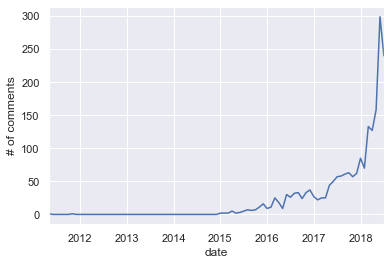

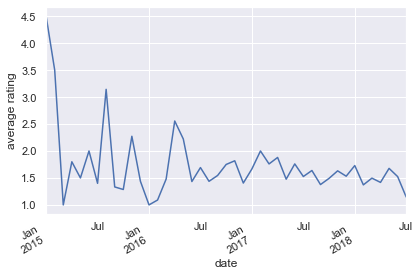

In [25]:
data['star_rating'].resample('M').size().plot()

plt.ylabel('# of comments')
plt.show()

star_rating=data['star_rating'].resample('M').mean()

gr=star_rating['2015':].plot(subplots=True)
plt.ylabel('average rating')
plt.tight_layout()
plt.show()


We can observe that in past people prefered not to comment but they might have complains. So in data we have only 2 comments in 2011 and then mostly comments came from 2015. Therefore, it seems the complain system became easily accesseble after certain changes in the system. Then people got more awareness and started registering their complains. Moreover, the complains or commments in 2011 might not be relevant in 2015. We will see that later on. We can say that most of the time average star rating remained < 2.

Now we are interested to see if this behavior stands for all the train lines or just happening due to a subset of the train lines.

In [26]:
train_rating=data[['train_type','star_rating']].groupby(['train_type']).resample('M').mean()
train_rating

star_rating
train_type            date                                  
arrivatrainswales     2017-12-31 00:00:00+00:00     1.000000
                      2018-01-31 00:00:00+00:00     1.000000
                      2018-02-28 00:00:00+00:00     3.500000
                      2018-03-31 00:00:00+00:00     1.000000
                      2018-04-30 00:00:00+00:00     2.666667
...                                                      ...
virgintrainseastcoast 2018-03-31 00:00:00+00:00     1.545455
                      2018-04-30 00:00:00+00:00     2.166667
                      2018-05-31 00:00:00+00:00     2.250000
                      2018-06-30 00:00:00+00:00     1.500000
                      2018-07-31 00:00:00+00:00     1.000000

[483 rows x 1 columns]

### Sentiment Analysis

Along with the star rating lets also look at the sentiment scores across the period of interest.

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

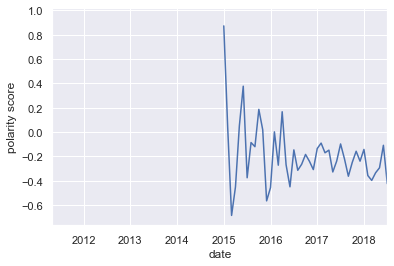

In [28]:
data['sentiment']=data['comments'].apply(lambda x: vader.polarity_scores(x)['compound'])

data['sentiment'].resample('M').mean().plot()
plt.ylabel('polarity score')
plt.show()

On average the sentiment scores remained negative over the period of interest, which complements the star rating behavior. 

### Topic extraction

Lets explore what sort of complain mostly people file. We can do this using unsupervised topic extractor models i.e. LDA

In [29]:
import gensim
from gensim import corpora
import pyLDAvis.gensim

from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


Lda = gensim.models.ldamodel.LdaModel
pyLDAvis.enable_notebook()

/Users/zaheerbabar/opt/anaconda3/envs/okra/lib/python3.6/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [30]:
def extract_topic(corpus, num_topics=10, n_words=10):
    
    clean_corpus=corpus.str.split(' ').tolist()
    
    dict_ = corpora.Dictionary(clean_corpus)
    
    doc_term_matrix = [dict_.doc2bow(i) for i in clean_corpus]

    ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dict_, passes=1, random_state=0, eval_every=None,iterations=100)
#     ldamodel=Lda(corpus=doc_term_matrix ,id2word=dict_,num_topics=num_topics, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=10,
#                                            passes=10,
#                                            alpha='symmetric',
#                                            iterations=100,
#                                            per_word_topics=True)
    #     vis = pyLDAvis.gensim.prepare(ldamodel, clean_corpus, dictionary=ldamodel.id2word)
#     print(vis)
    return ldamodel,ldamodel.print_topics(num_topics=num_topics, num_words=n_words),ldamodel.show_topics(formatted=False),doc_term_matrix

def cloud_generate(topics,size=5):
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    fig, axes = plt.subplots(2,size, figsize=(10,10), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

We can use LDA to extract frequently discussed topics in particular corpus. Each topic consist of n number of words. Lets extract top 10 topics each consisting 8 words

In [31]:
ldamodel,show_topics,topics, corpus=extract_topic(data['comments'],10,8)

print(show_topics)



[(0, '0.046*"train" + 0.046*"crowding" + 0.024*"service" + 0.020*"delay" + 0.016*"ticket" + 0.016*"awful" + 0.015*"destination" + 0.015*"terrible"'), (1, '0.256*"review" + 0.256*"possible" + 0.128*"star" + 0.023*"inadequate" + 0.021*"unacceptable" + 0.014*"train" + 0.011*"service" + 0.011*"occasion"'), (2, '0.059*"day" + 0.056*"delay" + 0.055*"star" + 0.043*"train" + 0.033*"service" + 0.025*"celebrate" + 0.025*"swr" + 0.008*"time"'), (3, '0.042*"train" + 0.021*"bad" + 0.013*"service" + 0.012*"company" + 0.011*"time" + 0.010*"travel" + 0.010*"journey" + 0.009*"ticket"'), (4, '0.023*"train" + 0.015*"service" + 0.007*"use" + 0.007*"nightmare" + 0.006*"total" + 0.006*"disgraceful" + 0.006*"ticket" + 0.006*"incompetent"'), (5, '0.053*"train" + 0.046*"overcrowded" + 0.042*"manchester" + 0.034*"cram" + 0.032*"carriage" + 0.031*"service" + 0.030*"shoddy" + 0.029*"hour"'), (6, '0.058*"train" + 0.037*"service" + 0.032*"delay" + 0.029*"final" + 0.028*"aboard" + 0.027*"cancellation" + 0.026*"termi

In the above extracted topics we can try to make sense about the probable problems. 

1- Mostly people are talking about the bad service.
2- Train delay is the common issue. So mostly passengers arrived late.
3- Usual overcrowded trains especially in peak hours. 
4- On the top of that customer service of most the train lines is also poor.
5- Web portals especially ticketing service is also poort.

Lets visualize these common topic using word cloud.

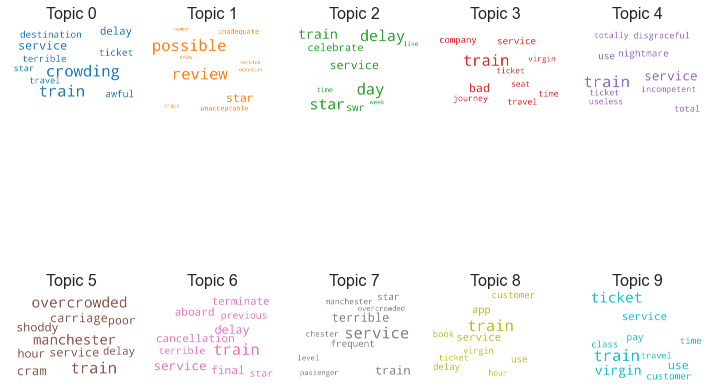

In [32]:
cloud_generate(topics,size=5)

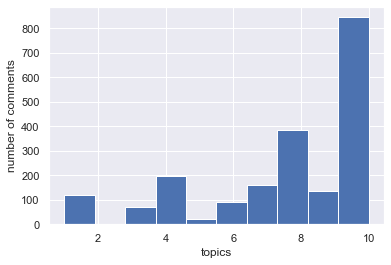

In [33]:
docs=[i for i in ldamodel[corpus]]

docs_max=[max(d)[0]+1 for d in docs]
  
plt.hist(docs_max,bins=10)
plt.xlabel('topics')
plt.ylabel('number of comments')
plt.show()

Above figure depicst number of comments with topic t as a best topic. Here, we see that topic 1 is not a best topic for of any of the comment. If we look at topic # 1 (review, possible, star, inadequate, unacceptable, train, service, occasion) collectively doesnt make sense at all.

Let see how problems remained year to year. We consider 2015 onward because in 2011 we have only two comments. 

In [34]:
_,show_topics,topics,_ =extract_topic(data['2015']['comments'],8,8)

print(show_topics)



[(0, '0.029*"train" + 0.015*"journey" + 0.013*"try" + 0.010*"hour" + 0.009*"virgin" + 0.009*"seat" + 0.009*"service" + 0.009*"staff"'), (1, '0.020*"virgin" + 0.018*"customer" + 0.018*"service" + 0.017*"train" + 0.013*"book" + 0.011*"seat" + 0.011*"voucher" + 0.011*"staff"'), (2, '0.026*"train" + 0.022*"service" + 0.021*"customer" + 0.020*"ticket" + 0.019*"virgin" + 0.013*"journey" + 0.011*"travel" + 0.010*"problem"'), (3, '0.020*"ticket" + 0.017*"train" + 0.015*"use" + 0.012*"good" + 0.010*"journey" + 0.010*"buy" + 0.008*"manchester" + 0.008*"website"'), (4, '0.015*"new" + 0.015*"bad" + 0.012*"london" + 0.010*"ticket" + 0.010*"website" + 0.010*"summary" + 0.009*"train" + 0.007*"journey"'), (5, '0.050*"ticket" + 0.023*"use" + 0.020*"card" + 0.017*"buy" + 0.016*"discount" + 0.012*"man" + 0.009*"service" + 0.009*"purchase"'), (6, '0.030*"train" + 0.025*"ticket" + 0.019*"time" + 0.015*"seat" + 0.015*"book" + 0.014*"london" + 0.014*"virgin" + 0.013*"customer"'), (7, '0.039*"train" + 0.025*"

So we see that in 2015 mostly problems were related to the web portals, ticketing and seating. As per the comments mostly problems were related to the virgintrains.

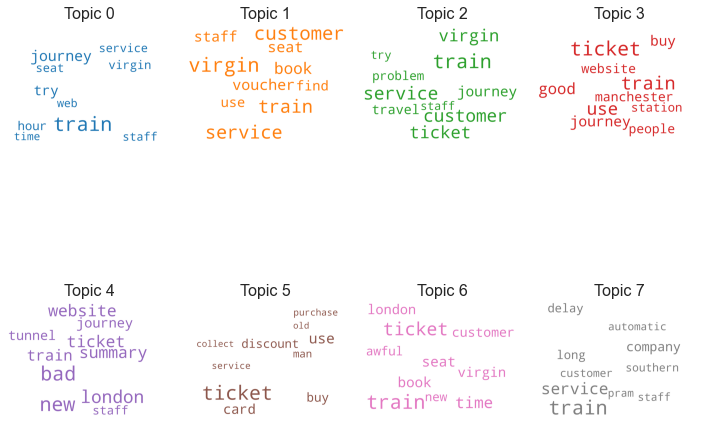

In [35]:
cloud_generate(topics, size=4)

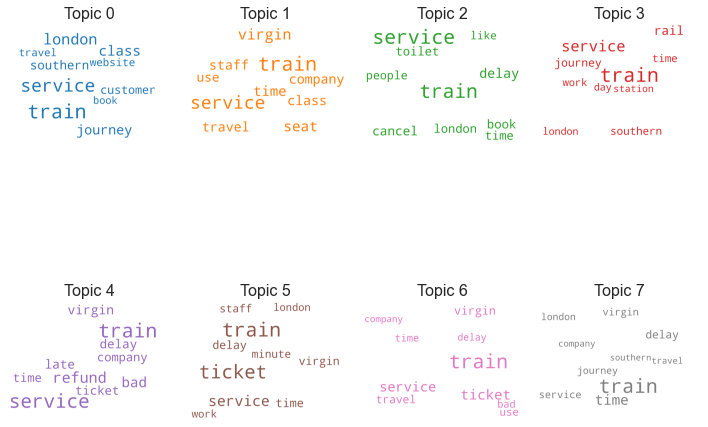

In [36]:
_,show_topics,topics,_=extract_topic(data['2016']['comments'],8,8)

#print(show_topics)
cloud_generate(topics, size=4)


So in 2016 seating and other service related problems exist. Along with that train delays issues can be noticed.

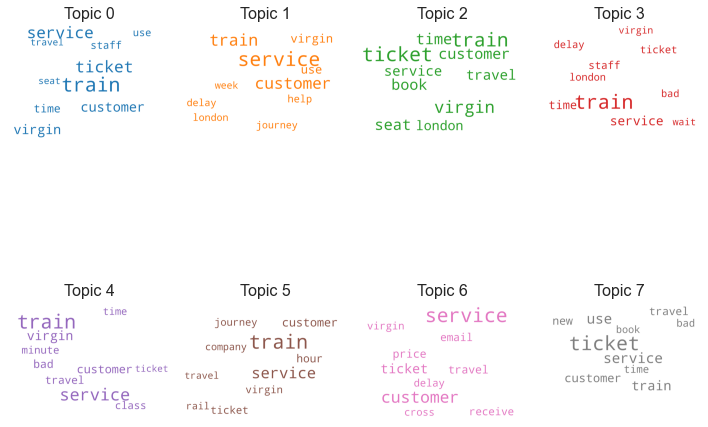

In [37]:
_,show_topics,topics,_=extract_topic(data['2017']['comments'],8,8)

#print(show_topics)
cloud_generate(topics, size=4)

In 2017 people mostly complained about unsuitable new train timings along with delays. Moreover, they complained about the poor response from virgin train and customer support staff.

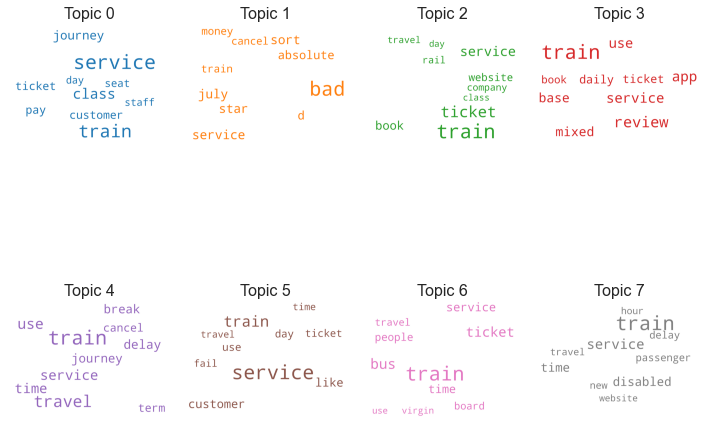

In [38]:
_,show_topics,topics,_=extract_topic(data['2018']['comments'],10,8)

#print(show_topics)
cloud_generate(topics, size=4)

In 2018 most of the problem remained as it is: 1) train delays 2) poor customer service 3) bad ticketing service and 4) unsuitable timings

### Conclusion

One the base of all the above stats we can put our findings as:

1- Most of the comments came from 2015. It might be due to poor complain filing service or otherwise people didnt care to file a complain or comment.

2- Average rating remained poor through this period. So the sentiments of the passengers also remained mostly negative. Hence, mostly passengers were angry and not satisfied with the services across all the train lines especially most frequent lines including virgin trains, national rail, gwr, eurostar, and southren railway.

3- Mostly complains were about virgin trains. That is understandable because virgin group use to have frequent trains but most importantly they suffered with poor punctuality compared with some others.

4- Here are the frequent complains which remained dominent through the period of interest
        
        - People face difficulty while booking the seats due to the bad ticketing service along with the poor response from the onboard relevant staff.
        - Train delays: Most of the trains get late and on the top of that passengers face poor cutomer service in this regard.
        - New timings: There are some objections over the suitability of the new timings
        - Overcrowded trains especially in peak timings.
        
        





In addition to the all the operations I have done, I would have done Named Entity Recognition to identify the places or train routes where the problem is in abundance. Moreover, I would have used embeddings to find inter topic relevance.